In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import re
import json

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
prefix = '/content/gdrive/MyDrive/Selected_Storms_curated/'


# Load Data

In [4]:
from cProfile import label
from genericpath import isdir
from xml.sax.saxutils import prepare_input_source

datalist = []
for storm_dir in os.listdir(prefix):
    if storm_dir == ".DS_Store":
        continue
    storm_folder_path = os.path.join(prefix, storm_dir)
    if os.path.isdir(storm_folder_path):
        image_files = [
            file
            for file in os.listdir(storm_folder_path)
            if file.endswith((".jpg", ".jpeg"))
        ]
        for imfile in image_files:
            split_names = re.split(r"[_.]", imfile)
            split_names = [part for part in split_names if part]
            name = split_names[0]
            num = split_names[1]
            labelfile = os.path.join(
                storm_folder_path, name + "_" + num + "_label.json"
            )
            with open(labelfile, "r") as json_file:
                # read json label file
                json_data = json.load(json_file)
                wind_speed = json_data["wind_speed"]
            featuresfile = os.path.join(
                storm_folder_path, name + "_" + num + "_features.json"
            )
            with open(featuresfile, "r") as json_file:
                # read json feature file
                json_data = json.load(json_file)
                relative_time = json_data["relative_time"]
                ocean = json_data["ocean"]
                storm_name = json_data["storm_id"]
            datalist.append(
                {
                    "Storm_Name": storm_name,
                    "Id": int(num),
                    "Wind_Speed": int(wind_speed),
                    "Relative_time": int(relative_time),
                    "Ocean": int(ocean),
                    "Image_Path": os.path.join(storm_folder_path, imfile),
                }
            )

data = pd.DataFrame(datalist)

In [5]:
data

,Storm_Name,Id,Wind_Speed,Relative_time,Ocean,Image_Path
0,hig,289,100,826198,1,/content/gdrive/MyDrive/Selected_Storms_curate...
1,hig,311,92,874800,1,/content/gdrive/MyDrive/Selected_Storms_curate...
2,hig,0,30,0,1,/content/gdrive/MyDrive/Selected_Storms_curate...
3,hig,262,105,748798,1,/content/gdrive/MyDrive/Selected_Storms_curate...
4,hig,203,90,583199,1,/content/gdrive/MyDrive/Selected_Storms_curate...
...,...,...,...,...,...,...
9522,bkh,3,25,5400,1,/content/gdrive/MyDrive/Selected_Storms_curate...
9523,bkh,208,36,532802,1,/content/gdrive/MyDrive/Selected_Storms_curate...
9524,bkh,18,25,46802,1,/content/gdrive/MyDrive/Selected_Storms_curate...
9525,bkh,67,52,174600,1,/content/gdrive/MyDrive/Selected_Storms_curate...


The training data consist of images identified by a storm name and id, where storm_id is a unique three letter code and image_number represents the sequential ordering of images throughout that storm.

In [7]:
data.to_csv('/content/gdrive/MyDrive/all_data.csv', index=False)


## Evaluate
Let's take a look at how many storms are in the training data, and how many images we have per storm.

In [31]:
data.Storm_Name.nunique()

30

In [33]:
storm_counts = data.groupby("Storm_Name").size()
storm_counts.describe()

count     30.000000
mean     317.566667
std      100.075035
min      155.000000
25%      244.500000
50%      312.500000
75%      396.250000
max      498.000000
dtype: float64


Let's take a look at how many images we have per storm.

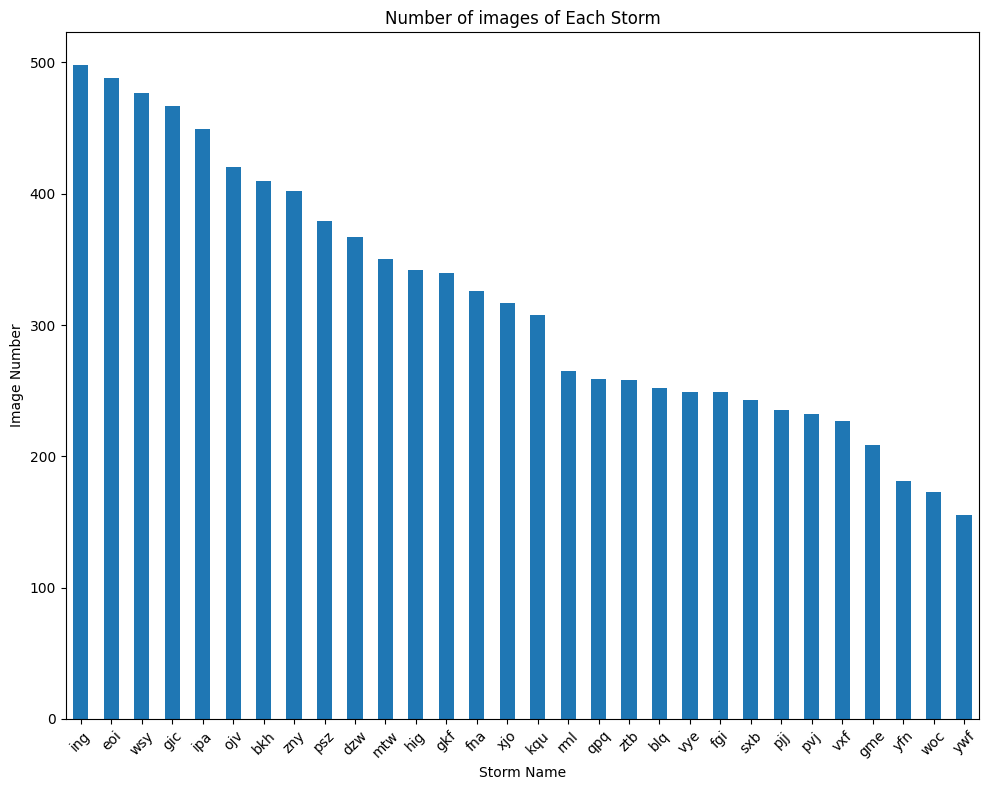

In [34]:
storm_name_counts = data["Storm_Name"].value_counts()
plt.figure(figsize=(10, 8))
storm_name_counts.plot(kind="bar")
plt.title("Number of images of Each Storm")
plt.xlabel("Storm Name")
plt.ylabel("Image Number")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The training data contain images from 30 storms. We have anywhere from 155 to 498 images per unique storm, with many storms containing fewer than 300 images.

We can also take a look at how many storms come from each ocean.

In [11]:
ocean_storm_counts = data["Ocean"].value_counts()
ocean_storm_counts

1    7652
2    1875
Name: Ocean, dtype: int64

Next, let's explore the overall distribution of wind speeds in the training data

In [9]:
data["Wind_Speed"].describe()

count    9527.000000
mean       58.020153
std        26.169805
min        20.000000
25%        36.000000
50%        54.000000
75%        74.000000
max       150.000000
Name: Wind_Speed, dtype: float64

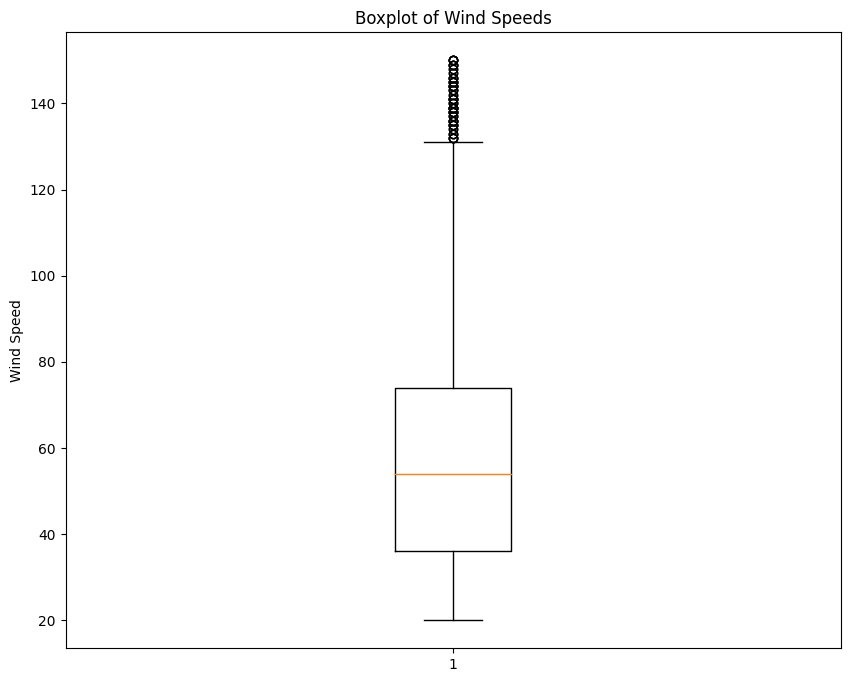

In [10]:
data["Wind_Speed"] = pd.to_numeric(data["Wind_Speed"], errors="coerce")
plt.figure(figsize=(10, 8))
plt.boxplot(data["Wind_Speed"])
plt.title("Distribution of Wind Speeds")
plt.ylabel("Wind Speed")
plt.show()

Boxplot displaying wind speed distribution with outliers. Median around 50, large spread, maximum values exceed 140. A majority of images fall between 36 and 74 knots

Given the temporal nature of storm and wind patterns, relative time will be an important correlate of wind speed for task2. Our data contains a relative time field since the beginning of a storm. We can see how wind speeds change over the course of a storm

In [14]:
def plot_wind_speeds(data: pd.DataFrame, storm_name: str) -> None:
    storm = data[data.Storm_Name == storm_name]
    storm = storm.sort_values(by="Relative_time")
    plt.figure(figsize=(12, 4))
    plt.plot(storm["Relative_time"], storm["Wind_Speed"], color="lightgray")
    plt.ticklabel_format(useOffset=False)
    plt.ylabel("Wind Speed")
    plt.title(f"Wind Speed over Relative Time: Storm {storm_name}")

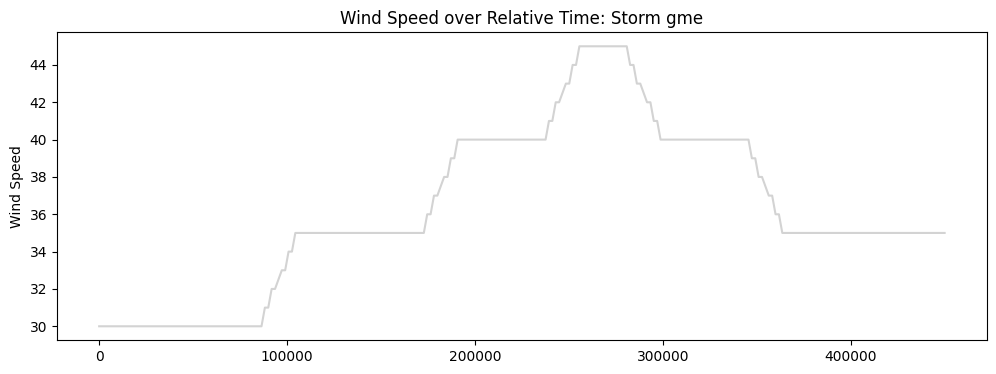

In [15]:
plot_wind_speeds(data, "gme")

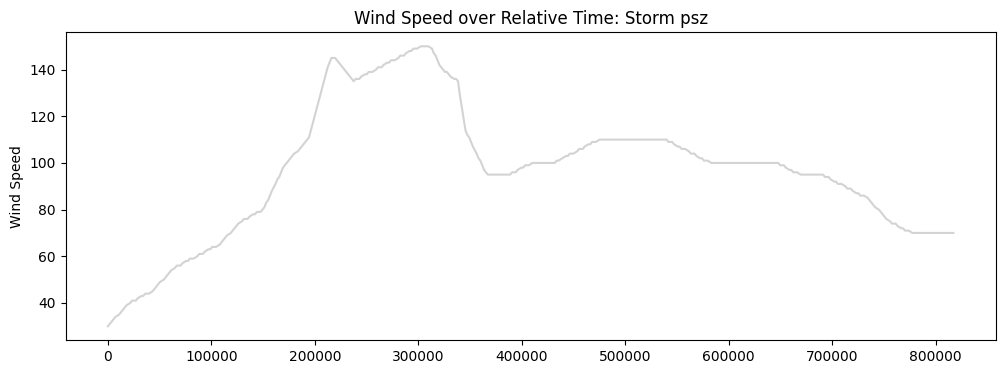

In [16]:
plot_wind_speeds(data, "psz")

For storm gme, wind speeds start at around 30 knots and show a stepwise increase peaking above 44 knots before plateauing and ending abruptly, suggesting missing data towards the end. In contrast, storm psz begins at about 40 knots, surges sharply to a peak above 140 knots, and then gradually declines. Both graphs show a distinct correlation between time and wind speed, indicating a trend that could be predictive for modeling purposes, despite apparent data gaps in storm gme.

In [12]:
sorted_data = data[data.Storm_Name == "gme"].sort_values(by="Relative_time")

In [13]:
sorted_data

,Storm_Name,Id,Wind_Speed,Relative_time,Ocean,Image_Path
397,gme,0,30,0,1,/content/gdrive/MyDrive/Selected_Storms_curate...
490,gme,1,30,1800,1,/content/gdrive/MyDrive/Selected_Storms_curate...
484,gme,2,30,3600,1,/content/gdrive/MyDrive/Selected_Storms_curate...
498,gme,3,30,5400,1,/content/gdrive/MyDrive/Selected_Storms_curate...
422,gme,4,30,7200,1,/content/gdrive/MyDrive/Selected_Storms_curate...
...,...,...,...,...,...,...
433,gme,204,35,442801,1,/content/gdrive/MyDrive/Selected_Storms_curate...
350,gme,205,35,444601,1,/content/gdrive/MyDrive/Selected_Storms_curate...
431,gme,206,35,446402,1,/content/gdrive/MyDrive/Selected_Storms_curate...
416,gme,207,35,448201,1,/content/gdrive/MyDrive/Selected_Storms_curate...


Take a look at some of the storm imagery

In [17]:
from PIL import Image


def show_storm_image(data: pd.DataFrame, storm_name: str) -> None:
    data = data[data.Storm_Name == storm_name]
    data = data.sort_values(by="Wind_Speed")
    max_idx = len(data) - 1
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        tmp = data.iloc[int(max_idx/4*(i+1))]
        im = Image.open(tmp["Image_Path"])
        axs[i].imshow(im, cmap="gray")
        axs[i].set_title(f'{storm_name} at speed of {tmp["Wind_Speed"]}')

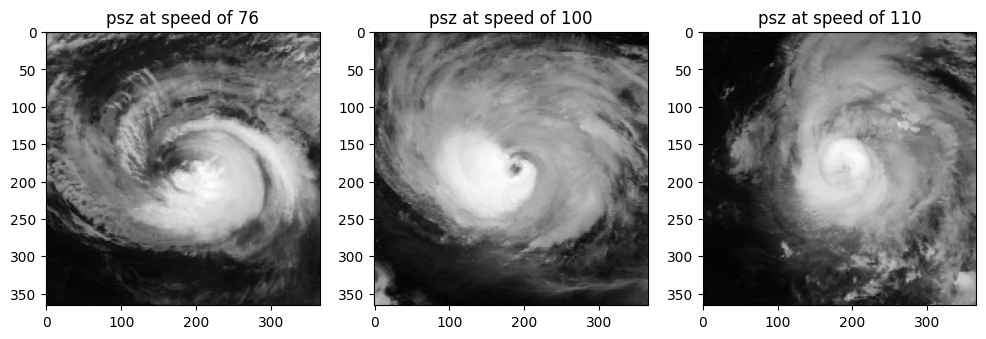

In [18]:
show_storm_image(data, "psz")

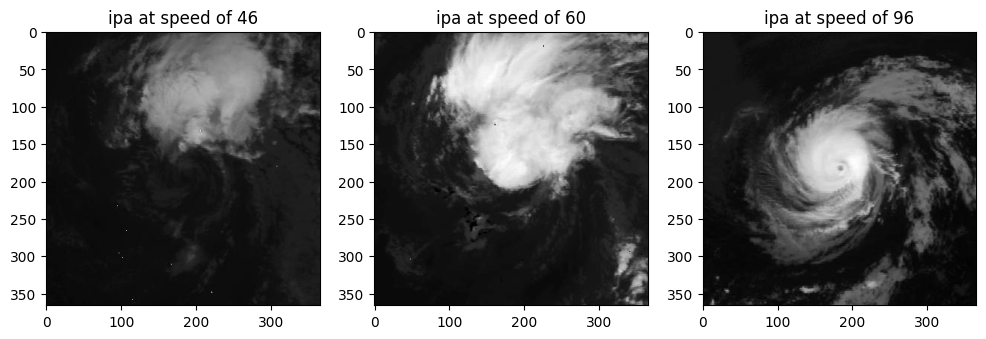

In [19]:
show_storm_image(data, "ipa")

With each increase in wind speed, we can see noticeable changes in storm structure and intensity. An effective model will be able to detect these types of patterns at scale.

Finally, let's confirm that the first few images are the expected size of 366 x 366 pixels

In [40]:
from PIL import Image as pil_image
examples = [
    pil_image.open(data.iloc[i]["Image_Path"]).convert("RGB") for i in range(5)
]
for image in examples:
    print(image.size)

(366, 366)
(366, 366)
(366, 366)
(366, 366)
(366, 366)


Sort the data of storm "gme" by Relative_time

In [ ]:
sorted_data.to_csv('/content/gdrive/MyDrive/sorted_data_V0.csv', index=False)

In [43]:
sorted_data

,Storm_Name,Id,Wind_Speed,Relative_time,Ocean,Image_Path
397,gme,0,30,0,1,/content/gdrive/MyDrive/Selected_Storms_curate...
490,gme,1,30,1800,1,/content/gdrive/MyDrive/Selected_Storms_curate...
484,gme,2,30,3600,1,/content/gdrive/MyDrive/Selected_Storms_curate...
498,gme,3,30,5400,1,/content/gdrive/MyDrive/Selected_Storms_curate...
422,gme,4,30,7200,1,/content/gdrive/MyDrive/Selected_Storms_curate...
...,...,...,...,...,...,...
433,gme,204,35,442801,1,/content/gdrive/MyDrive/Selected_Storms_curate...
350,gme,205,35,444601,1,/content/gdrive/MyDrive/Selected_Storms_curate...
431,gme,206,35,446402,1,/content/gdrive/MyDrive/Selected_Storms_curate...
416,gme,207,35,448201,1,/content/gdrive/MyDrive/Selected_Storms_curate...
